In [5]:
! pip install -q yfinance numpy pandas

In [6]:
import yfinance

In [7]:
tickers = ['AAPL', 'NVO']
timeframe = '5y' # 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max

In [8]:
data = yfinance.download(tickers, period=timeframe, rounding=True,)
for ticker in data['Close'].columns:
    stock = yfinance.Ticker(ticker)

    market_cap = stock.info.get('marketCap', None)
    total_debt = stock.info.get('totalDebt', None)
    cash = stock.info.get('totalCash', None)
    ebit = stock.financials.loc['Operating Income', :].iloc[0] if 'Operating Income' in stock.financials.index else None

    # EV/EBIT
    if market_cap and total_debt and cash and ebit:
        ev = market_cap + total_debt - cash
        ev_ebit = ev / ebit if ebit else None
    else:
        ev_ebit = None

    # ROIC (assuming 21% tax rate)
    nopat = ebit * (1 - 0.21) if ebit else None
    invested_capital = (total_debt + market_cap - cash) if total_debt and cash else None
    roic = nopat / invested_capital if nopat and invested_capital else None

    # Write
    data['Daily Change (%)', ticker] = data['Close'][ticker].pct_change() * 100
    data['30-Day Change (%)', ticker] = (data['Close'][ticker] / data['Close'][ticker].shift(30) - 1) * 100
    data['1-Year Change (%)', ticker] = (data['Close'][ticker] / data['Close'][ticker].shift(252) - 1) * 100
    # Add Year-to-Date (YTD) Change for each ticker
    # Get the first trading day of the year for each ticker
    first_day_price = data['Close'][ticker].loc[data.index[data.index.year == data.index[-1].year].min()]
    data['Year-To-Date Change (%)', ticker] = (data['Close'][ticker] / first_day_price - 1) * 100
    data['Industry', ticker] = stock.info.get('industry', None)
    data['EV/EBIT', ticker] = ev_ebit
    data['ROIC (%)', ticker] = roic * 100

# Save to CSV
data.to_csv('data.csv', index=False)
data

[*********************100%***********************]  2 of 2 completed


Price        Close           High            Low           Open         \
Ticker        AAPL    NVO    AAPL    NVO    AAPL    NVO    AAPL    NVO   
Date                                                                     
2020-01-09   75.05  26.89   75.24  27.02   74.21  26.83   74.47  26.84   
2020-01-10   75.21  27.47   75.78  27.65   74.71  27.32   75.28  27.38   
2020-01-13   76.82  27.60   76.85  27.74   75.41  27.50   75.53  27.70   
2020-01-14   75.78  27.89   76.97  27.94   75.66  27.51   76.76  27.51   
2020-01-15   75.46  29.20   76.47  29.34   75.03  28.77   75.58  28.78   
...            ...    ...     ...    ...     ...    ...     ...    ...   
2025-01-02  243.85  87.52  249.10  88.51  241.82  87.19  248.93  87.91   
2025-01-03  243.36  87.65  244.18  88.19  241.89  87.34  243.36  87.49   
2025-01-06  245.00  85.03  247.33  86.34  243.20  84.80  244.31  86.11   
2025-01-07  242.21  83.34  245.55  84.81  241.35  82.64  242.98  84.10   
2025-01-08  242.70  85.64  243.71  85.80  240.05  84.68  241.92  85.51   

Price          Volume            ...              Industry    EV/EBIT  \
Ticker           AAPL       NVO  ...                  AAPL       AAPL   
Date                             ...                                    
2020-01-09  170108400   1842000  ...  Consumer Electronics  30.211114   
2020-01-10  140644800   2943000  ...  Consumer Electronics  30.211114   
2020-01-13  121532000   2380400  ...  Consumer Electronics  30.211114   
2020-01-14  161954400   2506200  ...  Consumer Electronics  30.211114   
2020-01-15  121923600   5969000  ...  Consumer Electronics  30.211114   
...               ...       ...  ...                   ...        ...   
2025-01-02   55740700   4570300  ...  Consumer Electronics  30.211114   
2025-01-03   40244100   3769000  ...  Consumer Electronics  30.211114   
2025-01-06   45045600  10695700  ...  Consumer Electronics  30.211114   
2025-01-07   40856000   9567900  ...  Consumer Electronics  30.211114   
2025-01-08   37564700   9193100  ...  Consumer Electronics  30.211114   

Price       ROIC (%) Daily Change (%) 30-Day Change (%) 1-Year Change (%)  \
Ticker          AAPL              NVO               NVO               NVO   
Date                                                                        
2020-01-09  2.614932              NaN               NaN               NaN   
2020-01-10  2.614932         2.156936               NaN               NaN   
2020-01-13  2.614932         0.473244               NaN               NaN   
2020-01-14  2.614932         1.050725               NaN               NaN   
2020-01-15  2.614932         4.697024               NaN               NaN   
...              ...              ...               ...               ...   
2025-01-02  2.614932         1.743781        -12.313395        -13.346535   
2025-01-03  2.614932         0.148537        -14.596122        -14.479461   
2025-01-06  2.614932        -2.989161        -19.226750        -20.129626   
2025-01-07  2.614932        -1.987534        -18.795674        -20.499857   
2025-01-08  2.614932         2.759779        -18.484675        -18.624097   

Price      Year-To-Date Change (%)                      Industry   EV/EBIT  \
Ticker                         NVO                           NVO       NVO   
Date                                                                         
2020-01-09              -69.275594  Drug Manufacturers - General  3.458621   
2020-01-10              -68.612888  Drug Manufacturers - General  3.458621   
2020-01-13              -68.464351  Drug Manufacturers - General  3.458621   
2020-01-14              -68.132998  Drug Manufacturers - General  3.458621   
2020-01-15              -66.636197  Drug Manufacturers - General  3.458621   
...                            ...                           ...       ...   
2025-01-02                0.000000  Drug Manufacturers - General  3.458621   
2025-01-03                0.148537  Drug Manufacturers - General  3.458621   
202

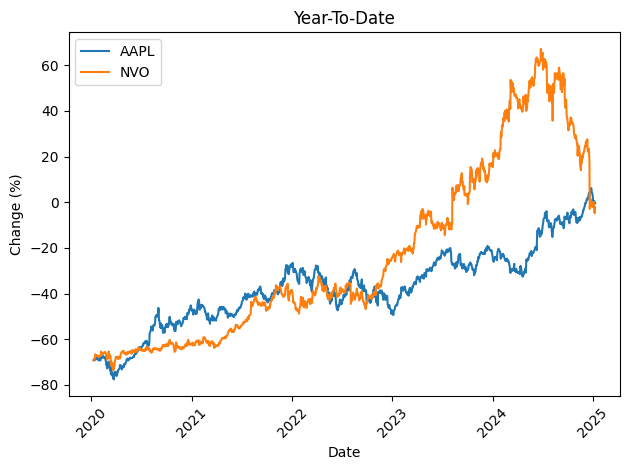

In [9]:
import matplotlib.pyplot as plt

for ticker in data['Year-To-Date Change (%)'].columns:
    plt.plot(data.index, data['Year-To-Date Change (%)'][ticker], label=ticker)

plt.xlabel('Date')
plt.ylabel('Change (%)')
plt.title('Year-To-Date')
plt.legend()
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()